In [75]:
import sys
import uproot3 as uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
import pickle
import xgboost as xgb

from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope
from tqdm import tqdm

In [2]:
%matplotlib inline
plt.ion()

In [3]:
# data frame to hold all data
datafile = uproot.open("/Users/patrick/Documents/MicroBooNE/CrossSections/NuePiXSec_Analysis/BDTTraining/TrainingTree_ElectronPhotonSeparation_withLooseCuts.root")["trainingTree"]

variables = (
    "isSignal",
    
    "shr_distance",
    "shr_trkfit_gap10_dedx_max",
    "shr_trkfit_2cm_dedx_max",
    "shrmoliereavg",
    "shr_energyFraction",
    "shrsubclusters",
    
    "shr_energy_second_cali",
    "shr2_distance",
    "shr12_p1_dstart",
    "shr_energy_third_cali",
    "shr3_distance",
    "shr13_p1_dstart",
    
    "secondshower_Y_nhit",
    "secondshower_Y_vtxdist",
    "secondshower_Y_anglediff",
    "secondshower_U_nhit",
    "secondshower_U_vtxdist",
    "secondshower_U_anglediff",
    "secondshower_V_nhit",
    "secondshower_V_vtxdist",
    "secondshower_V_anglediff"
)

df = pd.DataFrame(datafile.arrays(namedecode='utf-8', branches=variables))

# shuffle to avoid intrinsic sample being at start
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
print(df.shape) 
print(df.keys())
df.head()

(21710, 23)
Index(['isSignal', 'n_showers_contained', 'shr_distance',
       'shr_trkfit_gap10_dedx_max', 'shr_trkfit_2cm_dedx_max', 'shrmoliereavg',
       'shr_energyFraction', 'shrsubclusters', 'shr_energy_second_cali',
       'shr2_distance', 'shr12_p1_dstart', 'shr_energy_third_cali',
       'shr3_distance', 'shr13_p1_dstart', 'secondshower_Y_nhit',
       'secondshower_Y_vtxdist', 'secondshower_Y_anglediff',
       'secondshower_U_nhit', 'secondshower_U_vtxdist',
       'secondshower_U_anglediff', 'secondshower_V_nhit',
       'secondshower_V_vtxdist', 'secondshower_V_anglediff'],
      dtype='object')


,isSignal,n_showers_contained,shr_distance,shr_trkfit_gap10_dedx_max,shr_trkfit_2cm_dedx_max,shrmoliereavg,shr_energyFraction,shrsubclusters,shr_energy_second_cali,shr2_distance,...,shr13_p1_dstart,secondshower_Y_nhit,secondshower_Y_vtxdist,secondshower_Y_anglediff,secondshower_U_nhit,secondshower_U_vtxdist,secondshower_U_anglediff,secondshower_V_nhit,secondshower_V_vtxdist,secondshower_V_anglediff
0,True,2,0.195283,2.880149,2.855755,1.839577,0.979861,48.0,0.045093,1.557241,...,9999.0,27.0,49.480106,6.232941,14.0,110.074989,17.111534,52.0,0.456353,152.730469
1,True,1,7.337491,5.147478,4.391103,10.232785,1.000000,13.0,9999.000000,9999.000000,...,9999.0,13.0,76.808533,100.687668,3.0,28.669806,21.475098,4.0,47.853851,144.738403
2,True,1,0.586108,1.790180,2.089744,3.210809,1.000000,14.0,9999.000000,9999.000000,...,9999.0,10.0,59.531105,28.452618,11.0,33.271832,44.140442,20.0,0.311613,168.592896
3,False,1,6.998669,5.405616,3.257451,10.706463,1.000000,13.0,9999.000000,9999.000000,...,9999.0,26.0,260.711182,133.085754,9.0,34.502365,75.183739,2.0,49.944008,11.596859
4,True,1,0.604794,2.105556,2.571935,4.654350,1.000000,46.0,9999.000000,9999.000000,...,9999.0,18.0,197.535339,0.462067,9.0,75.984001,46.191605,11.0,13.641351,34.665722


In [5]:
# calculate neg / pos weight
scale_weight = (df.query('isSignal == 0')).shape[0] / (df.query('isSignal == 1')).shape[0]
print(scale_weight)

0.4123999739769696


In [6]:
# splitting into testing and training samples
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 1)
labels_train = df_train["isSignal"]
labels_test = df_test["isSignal"]

df_train_sig = df_train.query("isSignal == True")
df_train_bkg = df_train.query("isSignal == False")
df_test_sig = df_test.query("isSignal == True")
df_test_bkg = df_test.query("isSignal == False")

In [142]:
# convert to DMatrix format
missing_value = 9999
bdt_vars = {
    "n_showers_contained",
    "shr_distance",
    "shr_trkfit_gap10_dedx_max",
    "shr_trkfit_2cm_dedx_max",
    "shrmoliereavg",
    "shr_energyFraction",
    "shrsubclusters",
    "shr_energy_second_cali",
    "shr2_distance",
    "shr12_p1_dstart",
    "shr_energy_third_cali",
    "shr3_distance",
    "shr13_p1_dstart",
    "secondshower_Y_nhit",
    "secondshower_Y_vtxdist",
    "secondshower_Y_anglediff",
    "secondshower_U_nhit",
    "secondshower_U_vtxdist",
    "secondshower_U_anglediff",
    "secondshower_V_nhit",
    "secondshower_V_vtxdist",
    "secondshower_V_anglediff"
}

xgb_train_dict = xgb.DMatrix(df_train[bdt_vars], label=labels_train, missing=missing_value, feature_names=bdt_vars)
xgb_train_sig_dict = xgb.DMatrix(df_train_sig[bdt_vars], label=df_train_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
xgb_train_bkg_dict = xgb.DMatrix(df_train_bkg[bdt_vars], label=df_train_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)

xgb_test_dict = xgb.DMatrix(df_test[bdt_vars], label=labels_test, missing=missing_value, feature_names=bdt_vars)
xgb_test_sig_dict = xgb.DMatrix(df_test_sig[bdt_vars], label=df_test_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
xgb_test_bkg_dict = xgb.DMatrix(df_test_bkg[bdt_vars], label=df_test_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)

/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_47520/4116749271.py:28: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_dict = xgb.DMatrix(df_train[bdt_vars], label=labels_train, missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_47520/4116749271.py:29: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_sig_dict = xgb.DMatrix(df_train_sig[bdt_vars], label=df_train_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_47520/4116749271.py:30: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_bkg_dict = xgb.DMatrix(df_train_bkg[bdt_vars], label=df_train_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l6

In [82]:
# configuring XGBoost 
xgb_param = {'booster': 'dart',
        'max_depth':4,
        'eta': 0.03,
        'gamma': 1,
        'objective':'binary:logistic',
        'tree_method':'hist',
        'rate_drop': 0.1,
        'skip_drop': 0.5,
        'scale_pos_weight': scale_weight,
        'nthread' : 6,
        'random_state': 0 }

num_round = 1000
progress = dict()

watchlist = [(xgb_train_dict, 'train'), (xgb_test_dict, 'test'), (xgb_test_sig_dict, 'test_sig'), (xgb_test_bkg_dict, 'test_bkg')]

In [173]:
#{'colsample_bytree': 0.9731766939015076, 
# 'eta': 0.07227421126446018, 
# 'gamma': 1.4052896841285258, 
# 'max_depth': 5, 
# 'min_child_weight': 4.5489236838148805, 
# 'rate_drop': 0.08726252796589705, 
# 'skip_drop': 0.5448627045508394, 
# 'subsample': 0.7270183927863968}
#200

# configuring XGBoost (Optimised values using HyperOpt)
xgb_param = {'booster': 'dart',
        'max_depth':5,
        'eta': 0.07,ß
        'gamma': 1.4,
        'colsample_bytree': 0.95,
        'min_child_weight': 4.5,
        'subsample': 0.7,
        'objective':'binary:logistic',
        'tree_method':'hist',
        'rate_drop': 0.1,
        'skip_drop': 0.55,    
        'scale_pos_weight': scale_weight,
        'nthread' : 6,
        'random_state': 27} #27}

num_round = 500
progress = dict()

watchlist = [(xgb_train_dict, 'train'), (xgb_test_dict, 'test'), (xgb_test_sig_dict, 'test_sig'), (xgb_test_bkg_dict, 'test_bkg')]

In [174]:
# training
bdt = xgb.train(xgb_param, xgb_train_dict, num_round, watchlist, evals_result=progress, verbose_eval=False)

In [154]:
# save pickle 
pickle.dump(bdt, open("electronPhotonBDT.pickle.dat", "wb"))

In [155]:
# load from pickle
bdt = pickle.load(open("electronPhotonBDT.pickle.dat", "rb"))

In [176]:
# save model
bdt.save_model("bdt_electronPhoton.model")
bdt.save_model("bdt_electronPhoton.json")

In [157]:
bdt.dump_model("bdt_electronPhotondump.txt")

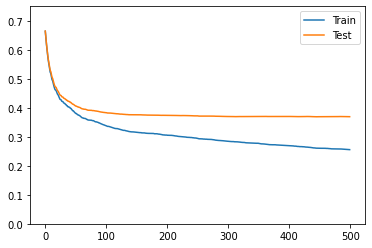

0.25579683141501863 0.3694274824586466


In [175]:
# plot training rate
results = progress
epochs = len(results['train']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['train']['logloss'], label='Train')
ax.plot(x_axis, results['test']['logloss'], label='Test')
ax.legend()
plt.ylim(0, 0.75)
plt.show()

print(results['train']['logloss'][-1], results['test']['logloss'][-1])
#plt.savefig("training_rate_electronphoton.pdf", format="pdf")

<Figure size 1440x1440 with 0 Axes>

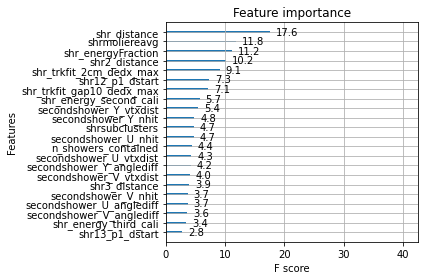

In [177]:
# plot importances
importance = bdt.get_score(importance_type="gain")

for key in importance.keys():
        importance[key] = round(importance[key],1)

# plotting importances of variables
plt.figure(figsize=(20,20),facecolor='white')
a = xgb.plot_importance(importance,max_num_features=30,importance_type='gain')
plt.xlim(0, 42.5)
plt.tight_layout()
#plt.savefig("feature_importance_electronphoton.pdf", format="pdf")

<Figure size 432x288 with 0 Axes>

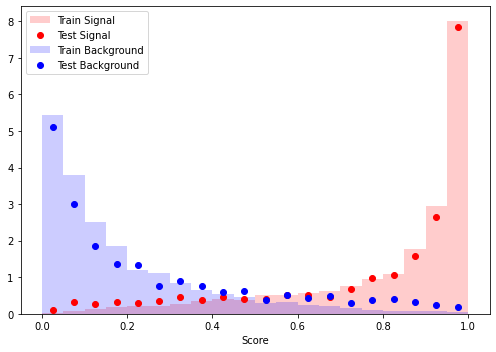

In [178]:
# plot test vs training
predictions_train_sig = bdt.predict(xgb_train_sig_dict)
predictions_train_bkg = bdt.predict(xgb_train_bkg_dict)
predictions_test_sig = bdt.predict(xgb_test_sig_dict)
predictions_test_bkg = bdt.predict(xgb_test_bkg_dict)

hist_range=[0,1.0]
n_bins=20

plt.figure(figsize=(7,5))
plt.hist(predictions_train_sig,bins=n_bins, range=hist_range, density=True,alpha=0.2,color='red',label='Train Signal' )
counts,bin_edges = np.histogram(predictions_test_sig,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers,counts,marker='o',linestyle="None",color='red',label='Test Signal')

plt.hist(predictions_train_bkg, bins = n_bins, range = hist_range, density = True, alpha = 0.2, color = 'blue', label = r'Train Background')
counts,bin_edges = np.histogram(predictions_test_bkg,bins = n_bins, range= hist_range,density = True)
bin_centers = (bin_edges[:-1] +  bin_edges[1:])/2.
plt.plot(bin_centers,counts,marker='o',linestyle ="None",color='blue',label = r'Test Background')
plt.legend()

plt.xlabel("Score")

plt.tight_layout()

#plt.savefig("performance_electronphoton.pdf", format="pdf")

<Figure size 432x288 with 0 Axes>

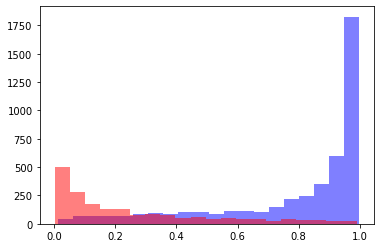

In [179]:
# create plot of predictions (testing samples)
num_bins = 20

plt.hist(predictions_test_sig, num_bins, color ='blue', alpha = 0.5)
plt.hist(predictions_test_bkg, num_bins, color ='red', alpha = 0.5)

plt.show()

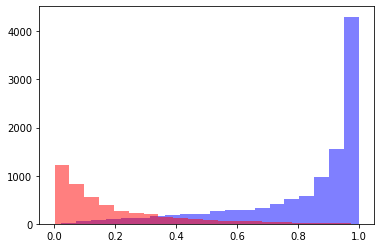

In [180]:
# create plot of predictions (training samples)
num_bins = 20
   
plt.hist(predictions_train_sig, num_bins, color ='blue', alpha = 0.5)
plt.hist(predictions_train_bkg, num_bins, color ='red', alpha = 0.5)

plt.show()

In [104]:
# Hyper parameter optimisation
# Un-tunded base case estimator to compare score
params_base = {'booster': 'dart',
               'objective': 'binary:logistic',
               'tree_method': 'hist',
               'rate_drop': 0.1,
               'skip_drop': 0.5,
               'scale_pos_weight': scale_weight,
               'random_state': 27}

base_model = xgb.train(params = params_base,
                       dtrain = xgb_train_dict,
                       num_boost_round = 1000,
                       evals = [(xgb_test_dict,'eval')],
                       early_stopping_rounds=10,
                       verbose_eval = 20)

y_pred_base = base_model.predict(xgb_test_dict)

base_score = log_loss(df_test["isSignal"].values, y_pred_base)
print(base_score)

[0]	eval-logloss:0.58131
[20]	eval-logloss:0.38273
[40]	eval-logloss:0.37745
[60]	eval-logloss:0.37433
[80]	eval-logloss:0.37332
[100]	eval-logloss:0.37271
[116]	eval-logloss:0.37424
0.3750617252617398


In [123]:
# Simple Cross Val score as function to be optimised
def score(params):
    
    ps = {'eta': params['eta'],
         'max_depth': params['max_depth'], 
         'gamma': params['gamma'],
         'min_child_weight': params['min_child_weight'], 
         'subsample': params['subsample'], 
         'colsample_bytree': params['colsample_bytree'], 
         'verbosity': 1, 
         'objective': 'binary:logistic',
         'booster': 'dart',
         'eval_metric': 'logloss', 
         'tree_method': 'hist', 
         'rate_drop': params['rate_drop'],
         'skip_drop': params['skip_drop'],    
         'scale_pos_weight': scale_weight,
         'random_state': 27,
         }
    model = xgb.train(ps,xgb_train_dict, params['n_round'], [(xgb_test_dict, 'eval')], early_stopping_rounds=10, verbose_eval = False)
    y_pred = model.predict(xgb_test_dict)
    score = log_loss(df_test["isSignal"].values, y_pred)

    return score

In [124]:
# Define parameter space
param_space = {'eta': hp.uniform('eta', 0.01, 0.3), 
               'n_round': scope.int(hp.quniform('n_round', 100, 1000, 50)),
               'max_depth': scope.int(hp.quniform('max_depth', 3, 5, 1)), 
               'gamma': hp.uniform('gamma', 0, 10), 
               'min_child_weight': hp.uniform('min_child_weight', 0, 10),
               'subsample': hp.uniform('subsample', 0.1, 1), 
               'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
               'rate_drop': hp.uniform('rate_drop', 0, 0.5),
               'skip_drop': hp.uniform('skip_drop', 0, 1)  
              }


In [125]:
# Run optimiser with tpe
%time
trials = Trials()

hopt = fmin(fn = score,
            space = param_space, 
            algo = tpe.suggest, 
            max_evals = 250, ## 100
            trials = trials, 
           )

params_best = hopt
params_best['max_depth'] = int(hopt['max_depth'])
n_rounds_best = int(hopt['n_round'])
del params_best['n_round']
print(params_best)
print(n_rounds_best)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 13.1 µs
  0%|▎                                                                 | 1/250 [00:01<06:57,  1.68s/trial, best loss: 0.38304608796145223]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  1%|▌                                                                 | 2/250 [00:04<09:46,  2.37s/trial, best loss: 0.38304608796145223]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  1%|▊                                                                 | 3/250 [00:07<11:12,  2.72s/trial, best loss: 0.38304608796145223]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  2%|█                                                                 | 4/250 [00:26<37:13,  9.08s/trial, best loss: 0.38304608796145223]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  2%|█▎                                                                | 5/250 [00:30<29:30,  7.23s/trial, best loss: 0.38304608796145223]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  2%|█▌                                                                | 6/250 [00:33<23:18,  5.73s/trial, best loss: 0.38304608796145223]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  3%|█▊                                                                | 7/250 [00:38<22:33,  5.57s/trial, best loss: 0.38304608796145223]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  3%|██                                                                | 8/250 [00:57<39:53,  9.89s/trial, best loss: 0.38304608796145223]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  4%|██▍                                                               | 9/250 [01:02<33:01,  8.22s/trial, best loss: 0.38304608796145223]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  4%|██▌                                                              | 10/250 [01:05<26:44,  6.68s/trial, best loss: 0.38304608796145223]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  4%|██▊                                                              | 11/250 [01:14<29:20,  7.36s/trial, best loss: 0.38269158078833365]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  5%|███                                                              | 12/250 [01:18<25:17,  6.38s/trial, best loss: 0.38269158078833365]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  5%|███▍                                                             | 13/250 [01:22<22:52,  5.79s/trial, best loss: 0.38269158078833365]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  6%|███▋                                                             | 14/250 [01:27<21:15,  5.41s/trial, best loss: 0.38269158078833365]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  6%|███▉                                                             | 15/250 [01:35<24:40,  6.30s/trial, best loss: 0.38269158078833365]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  6%|████▏                                                            | 16/250 [01:39<21:23,  5.48s/trial, best loss: 0.37990900165753316]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  7%|████▎                                                          | 17/250 [02:18<1:00:50, 15.67s/trial, best loss: 0.37990900165753316]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  7%|████▋                                                            | 18/250 [02:22<47:16, 12.23s/trial, best loss: 0.37990900165753316]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  8%|████▉                                                            | 19/250 [02:31<43:15, 11.24s/trial, best loss: 0.37990900165753316]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  8%|█████                                                          | 20/250 [05:17<3:40:33, 57.54s/trial, best loss: 0.37990900165753316]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  8%|█████▎                                                         | 21/250 [05:21<2:38:47, 41.60s/trial, best loss: 0.37990900165753316]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  9%|█████▌                                                         | 22/250 [05:28<1:57:55, 31.03s/trial, best loss: 0.37990900165753316]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  9%|██████████▊                                                                                                          | 23/250 [10:09<6:41:14, 106.05s/trial, best loss: 0.37990900165753316]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 10%|███████████▎                                                                                                          | 24/250 [10:35<5:09:35, 82.19s/trial, best loss: 0.37990900165753316]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 10%|███████████▊                                                                                                          | 25/250 [10:38<3:38:55, 58.38s/trial, best loss: 0.37990900165753316]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 10%|████████████▎                                                                                                         | 26/250 [10:49<2:44:38, 44.10s/trial, best loss: 0.37990900165753316]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 11%|████████████▊                                                                                                          | 27/250 [10:53<1:59:01, 32.03s/trial, best loss: 0.3774253243665082]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 11%|█████████████▎                                                                                                         | 28/250 [10:55<1:25:16, 23.05s/trial, best loss: 0.3774253243665082]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 12%|█████████████▊                                                                                                         | 29/250 [10:57<1:01:26, 16.68s/trial, best loss: 0.3774253243665082]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 12%|██████████████▌                                                                                                          | 30/250 [10:59<45:10, 12.32s/trial, best loss: 0.3774253243665082]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 12%|██████████████▉                                                                                                         | 31/250 [11:01<34:25,  9.43s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 13%|███████████████▎                                                                                                        | 32/250 [11:06<28:57,  7.97s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 13%|███████████████▊                                                                                                        | 33/250 [11:11<25:23,  7.02s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 14%|████████████████▎                                                                                                       | 34/250 [11:16<22:53,  6.36s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 14%|████████████████▊                                                                                                       | 35/250 [11:28<28:52,  8.06s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 14%|█████████████████▎                                                                                                      | 36/250 [11:34<26:43,  7.50s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 15%|█████████████████▊                                                                                                      | 37/250 [11:37<22:10,  6.24s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 15%|██████████████████▏                                                                                                     | 38/250 [11:44<22:24,  6.34s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 16%|██████████████████▋                                                                                                     | 39/250 [11:53<25:31,  7.26s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 16%|███████████████████▏                                                                                                    | 40/250 [11:54<18:50,  5.38s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 16%|███████████████████▋                                                                                                    | 41/250 [11:58<17:05,  4.91s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 17%|████████████████████▏                                                                                                   | 42/250 [12:03<17:16,  4.98s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 17%|████████████████████▋                                                                                                   | 43/250 [12:08<17:26,  5.05s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 18%|█████████████████████                                                                                                   | 44/250 [12:15<18:48,  5.48s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 18%|█████████████████████▏                                                                                                | 45/250 [13:14<1:13:37, 21.55s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 18%|█████████████████████▋                                                                                                | 46/250 [14:06<1:44:00, 30.59s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 19%|██████████████████████▏                                                                                               | 47/250 [14:11<1:17:42, 22.97s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 19%|███████████████████████                                                                                                 | 48/250 [14:13<56:54, 16.91s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 20%|███████████████████████▌                                                                                                | 49/250 [14:15<40:55, 12.21s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 20%|████████████████████████                                                                                                | 50/250 [14:21<34:39, 10.40s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 20%|████████████████████████▍                                                                                               | 51/250 [14:27<30:16,  9.13s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 21%|████████████████████████▉                                                                                               | 52/250 [14:29<23:04,  6.99s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 21%|█████████████████████████▍                                                                                              | 53/250 [14:30<17:03,  5.20s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 22%|█████████████████████████▉                                                                                              | 54/250 [14:32<13:40,  4.19s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 22%|██████████████████████████▍                                                                                             | 55/250 [14:35<12:17,  3.78s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 22%|██████████████████████████▉                                                                                             | 56/250 [14:36<09:20,  2.89s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 23%|███████████████████████████▎                                                                                            | 57/250 [14:40<11:04,  3.45s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 23%|███████████████████████████▊                                                                                            | 58/250 [14:51<18:22,  5.74s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 24%|████████████████████████████▎                                                                                           | 59/250 [14:59<20:28,  6.43s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 24%|████████████████████████████▊                                                                                           | 60/250 [15:07<21:37,  6.83s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 24%|█████████████████████████████▎                                                                                          | 61/250 [15:11<19:02,  6.05s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 25%|█████████████████████████████▊                                                                                          | 62/250 [15:15<16:48,  5.36s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 25%|██████████████████████████████▏                                                                                         | 63/250 [15:17<13:26,  4.31s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 26%|██████████████████████████████▋                                                                                         | 64/250 [15:26<17:49,  5.75s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 26%|███████████████████████████████▏                                                                                        | 65/250 [15:37<22:25,  7.27s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 26%|███████████████████████████████▋                                                                                        | 66/250 [15:42<20:35,  6.72s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 27%|████████████████████████████████▏                                                                                       | 67/250 [15:58<28:29,  9.34s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 27%|████████████████████████████████▋                                                                                       | 68/250 [16:04<25:13,  8.32s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 28%|████████████████████████████████▎                                                                                    | 69/250 [22:55<6:30:10, 129.34s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 28%|█████████████████████████████████                                                                                     | 70/250 [23:02<4:37:38, 92.55s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 28%|█████████████████████████████████▌                                                                                    | 71/250 [23:06<3:16:38, 65.91s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 29%|█████████████████████████████████▉                                                                                    | 72/250 [23:08<2:18:38, 46.74s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 29%|██████████████████████████████████▍                                                                                   | 73/250 [23:11<1:39:06, 33.59s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 30%|██████████████████████████████████▉                                                                                   | 74/250 [23:16<1:13:27, 25.04s/trial, best loss: 0.37722976537887437]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 30%|████████████████████████████████████                                                                                    | 75/250 [23:21<55:30, 19.03s/trial, best loss: 0.37693372691003874]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 30%|████████████████████████████████████▍                                                                                   | 76/250 [23:33<49:28, 17.06s/trial, best loss: 0.37693372691003874]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 31%|████████████████████████████████████▎                                                                                 | 77/250 [25:11<1:58:31, 41.11s/trial, best loss: 0.37693372691003874]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 31%|████████████████████████████████████▊                                                                                 | 78/250 [25:17<1:27:41, 30.59s/trial, best loss: 0.37693372691003874]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 32%|█████████████████████████████████████▎                                                                                | 79/250 [25:25<1:07:52, 23.81s/trial, best loss: 0.37693372691003874]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 32%|██████████████████████████████████████▍                                                                                 | 80/250 [25:32<53:01, 18.71s/trial, best loss: 0.37693372691003874]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 32%|██████████████████████████████████████▉                                                                                 | 81/250 [25:32<37:36, 13.35s/trial, best loss: 0.37693372691003874]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 33%|███████████████████████████████████████▎                                                                                | 82/250 [25:52<42:52, 15.31s/trial, best loss: 0.37693372691003874]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 33%|███████████████████████████████████████▊                                                                                | 83/250 [25:57<33:47, 12.14s/trial, best loss: 0.37693372691003874]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 34%|████████████████████████████████████████▎                                                                               | 84/250 [25:59<24:53,  9.00s/trial, best loss: 0.37693372691003874]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 34%|████████████████████████████████████████▊                                                                               | 85/250 [26:12<28:09, 10.24s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 34%|█████████████████████████████████████████▎                                                                              | 86/250 [26:38<40:52, 14.96s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 35%|█████████████████████████████████████████▊                                                                              | 87/250 [26:49<37:25, 13.78s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 35%|██████████████████████████████████████████▏                                                                             | 88/250 [26:52<28:50, 10.68s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 36%|██████████████████████████████████████████▋                                                                             | 89/250 [26:55<22:13,  8.28s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 36%|███████████████████████████████████████████▏                                                                            | 90/250 [27:12<28:53, 10.84s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 36%|███████████████████████████████████████████▋                                                                            | 91/250 [27:18<24:53,  9.39s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 37%|███████████████████████████████████████████▍                                                                          | 92/250 [29:13<1:48:43, 41.29s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 37%|███████████████████████████████████████████▉                                                                          | 93/250 [29:44<1:39:26, 38.00s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 38%|████████████████████████████████████████████▎                                                                         | 94/250 [29:45<1:10:03, 26.95s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 38%|█████████████████████████████████████████████▌                                                                          | 95/250 [29:50<52:48, 20.44s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 38%|██████████████████████████████████████████████                                                                          | 96/250 [29:59<43:34, 16.98s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 39%|██████████████████████████████████████████████▌                                                                         | 97/250 [30:15<42:06, 16.52s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 39%|███████████████████████████████████████████████                                                                         | 98/250 [30:25<37:20, 14.74s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 40%|███████████████████████████████████████████████▌                                                                        | 99/250 [31:09<59:09, 23.51s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 40%|███████████████████████████████████████████████▌                                                                       | 100/250 [31:17<46:56, 18.78s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 40%|███████████████████████████████████████████████▎                                                                     | 101/250 [33:53<2:28:48, 59.92s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 41%|███████████████████████████████████████████████▋                                                                     | 102/250 [34:03<1:51:18, 45.13s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 41%|████████████████████████████████████████████████▏                                                                    | 103/250 [34:17<1:27:26, 35.69s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 42%|████████████████████████████████████████████████▋                                                                    | 104/250 [34:25<1:06:19, 27.26s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 42%|█████████████████████████████████████████████████▉                                                                     | 105/250 [34:38<56:09, 23.24s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 42%|██████████████████████████████████████████████████▍                                                                    | 106/250 [34:56<51:46, 21.57s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 43%|██████████████████████████████████████████████████▉                                                                    | 107/250 [35:10<45:33, 19.11s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 43%|██████████████████████████████████████████████████▌                                                                  | 108/250 [39:54<3:53:32, 98.68s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 44%|███████████████████████████████████████████████████                                                                  | 109/250 [41:01<3:29:50, 89.30s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 44%|███████████████████████████████████████████████████▍                                                                 | 110/250 [41:17<2:36:30, 67.08s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 44%|███████████████████████████████████████████████████▉                                                                 | 111/250 [42:54<2:56:51, 76.34s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 45%|████████████████████████████████████████████████████▍                                                                | 112/250 [43:15<2:17:10, 59.64s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 45%|████████████████████████████████████████████████████▉                                                                | 113/250 [43:39<1:51:54, 49.01s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 46%|█████████████████████████████████████████████████████▎                                                               | 114/250 [44:10<1:38:34, 43.49s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 46%|█████████████████████████████████████████████████████▊                                                               | 115/250 [44:18<1:14:04, 32.92s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 46%|███████████████████████████████████████████████████████▏                                                               | 116/250 [44:23<54:26, 24.38s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 47%|██████████████████████████████████████████████████████▊                                                              | 117/250 [46:39<2:08:32, 57.99s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 47%|███████████████████████████████████████████████████████▏                                                             | 118/250 [46:50<1:36:45, 43.98s/trial, best loss: 0.37585771892613007]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 48%|████████████████████████████████████████████████████████▏                                                             | 119/250 [47:17<1:24:24, 38.66s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 48%|████████████████████████████████████████████████████████▋                                                             | 120/250 [47:23<1:02:29, 28.84s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 48%|██████████████████████████████████████████████████████████                                                              | 121/250 [47:28<46:46, 21.76s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 49%|██████████████████████████████████████████████████████████▌                                                             | 122/250 [47:35<37:14, 17.45s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 49%|███████████████████████████████████████████████████████████                                                             | 123/250 [47:49<34:22, 16.24s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 50%|███████████████████████████████████████████████████████████▌                                                            | 124/250 [47:54<27:08, 12.92s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 50%|████████████████████████████████████████████████████████████                                                            | 125/250 [48:33<43:13, 20.75s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 50%|████████████████████████████████████████████████████████████▍                                                           | 126/250 [48:43<36:32, 17.68s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 51%|████████████████████████████████████████████████████████████▉                                                           | 127/250 [49:09<41:05, 20.05s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 51%|█████████████████████████████████████████████████████████████▍                                                          | 128/250 [49:56<57:19, 28.19s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 52%|█████████████████████████████████████████████████████████████▉                                                          | 129/250 [50:00<42:06, 20.88s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 52%|██████████████████████████████████████████████████████████████▍                                                         | 130/250 [50:46<56:44, 28.37s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 52%|██████████████████████████████████████████████████████████████▉                                                         | 131/250 [51:20<59:31, 30.01s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 53%|██████████████████████████████████████████████████████████████▎                                                       | 132/250 [52:57<1:38:50, 50.26s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 53%|█████████████████████████████████████████████████████████████▏                                                     | 133/250 [1:00:15<5:24:59, 166.66s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 54%|█████████████████████████████████████████████████████████████▋                                                     | 134/250 [1:00:28<3:52:56, 120.48s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 54%|██████████████████████████████████████████████████████████████                                                     | 135/250 [1:05:18<5:28:24, 171.35s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 54%|██████████████████████████████████████████████████████████████▌                                                    | 136/250 [1:05:43<4:02:18, 127.53s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 55%|███████████████████████████████████████████████████████████████                                                    | 137/250 [1:12:56<6:52:40, 219.12s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 55%|███████████████████████████████████████████████████████████████▍                                                   | 138/250 [1:13:15<4:56:40, 158.93s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 56%|███████████████████████████████████████████████████████████████▉                                                   | 139/250 [1:20:54<7:40:39, 249.01s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 56%|████████████████████████████████████████████████████████████████▍                                                  | 140/250 [1:22:38<6:16:55, 205.59s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 56%|████████████████████████████████████████████████████████████████▊                                                  | 141/250 [1:22:56<4:31:12, 149.29s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 57%|█████████████████████████████████████████████████████████████████▎                                                 | 142/250 [1:23:34<3:28:30, 115.83s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 57%|██████████████████████████████████████████████████████████████████▎                                                 | 143/250 [1:23:42<2:28:58, 83.53s/trial, best loss: 0.3727110279192429]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 58%|██████████████████████████████████████████████████████████████████▊                                                 | 144/250 [1:24:31<2:09:23, 73.24s/trial, best loss: 0.3726382593349741]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 58%|██████████████████████████████████████████████████████████████████▋                                                | 145/250 [1:27:14<2:55:21, 100.21s/trial, best loss: 0.3726382593349741]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 58%|███████████████████████████████████████████████████████████████████▋                                                | 146/250 [1:27:42<2:16:08, 78.54s/trial, best loss: 0.3726382593349741]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 59%|███████████████████████████████████████████████████████████████████▌                                               | 147/250 [1:29:22<2:25:37, 84.83s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 59%|███████████████████████████████████████████████████████████████████▍                                              | 148/250 [1:33:51<3:58:17, 140.17s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 60%|███████████████████████████████████████████████████████████████████▉                                              | 149/250 [1:36:21<4:00:42, 143.00s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 60%|████████████████████████████████████████████████████████████████████▍                                             | 150/250 [1:42:23<5:48:08, 208.88s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 60%|████████████████████████████████████████████████████████████████████▊                                             | 151/250 [1:47:55<6:45:15, 245.61s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 61%|█████████████████████████████████████████████████████████████████████▎                                            | 152/250 [1:52:49<7:05:05, 260.26s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 61%|█████████████████████████████████████████████████████████████████████▊                                            | 153/250 [1:53:59<5:28:18, 203.07s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 62%|██████████████████████████████████████████████████████████████████████▏                                           | 154/250 [1:59:46<6:34:02, 246.27s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 62%|██████████████████████████████████████████████████████████████████████▋                                           | 155/250 [2:03:07<6:08:24, 232.68s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 62%|███████████████████████████████████████████████████████████████████████▏                                          | 156/250 [2:04:38<4:58:13, 190.36s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 63%|███████████████████████████████████████████████████████████████████████▌                                          | 157/250 [2:04:46<3:30:02, 135.51s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 63%|████████████████████████████████████████████████████████████████████████                                          | 158/250 [2:05:55<2:57:18, 115.64s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 64%|█████████████████████████████████████████████████████████████████████████▏                                         | 159/250 [2:06:20<2:13:52, 88.27s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 160/250 [2:07:02<1:51:32, 74.36s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 64%|██████████████████████████████████████████████████████████████████████████                                         | 161/250 [2:07:39<1:33:55, 63.33s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 65%|██████████████████████████████████████████████████████████████████████████▌                                        | 162/250 [2:07:52<1:10:35, 48.13s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 65%|██████████████████████████████████████████████████████████████████████████▉                                        | 163/250 [2:11:01<2:11:03, 90.38s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 66%|██████████████████████████████████████████████████████████████████████████▊                                       | 164/250 [2:14:18<2:55:24, 122.37s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 66%|███████████████████████████████████████████████████████████████████████████▉                                       | 165/250 [2:14:42<2:11:41, 92.96s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 66%|███████████████████████████████████████████████████████████████████████████▋                                      | 166/250 [2:19:44<3:37:45, 155.54s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 67%|████████████████████████████████████████████████████████████████████████████▏                                     | 167/250 [2:20:24<2:47:14, 120.89s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 168/250 [2:46:45<12:44:02, 559.06s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 68%|█████████████████████████████████████████████████████████████████████████████                                     | 169/250 [2:47:54<9:16:07, 411.94s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 68%|█████████████████████████████████████████████████████████████████████████████▌                                    | 170/250 [2:48:34<6:40:20, 300.26s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 68%|█████████████████████████████████████████████████████████████████████████████▉                                    | 171/250 [2:48:40<4:39:15, 212.09s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 69%|██████████████████████████████████████████████████████████████████████████████▍                                   | 172/250 [2:50:03<3:45:25, 173.40s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 69%|██████████████████████████████████████████████████████████████████████████████▉                                   | 173/250 [2:56:49<5:12:11, 243.26s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 70%|███████████████████████████████████████████████████████████████████████████████▎                                  | 174/250 [2:57:10<3:43:38, 176.56s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 175/250 [2:58:56<3:13:58, 155.18s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 70%|████████████████████████████████████████████████████████████████████████████████▎                                 | 176/250 [2:59:22<2:23:46, 116.57s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 71%|████████████████████████████████████████████████████████████████████████████████▋                                 | 177/250 [3:00:43<2:08:51, 105.91s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 71%|█████████████████████████████████████████████████████████████████████████████████▉                                 | 178/250 [3:01:49<1:52:47, 94.00s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 72%|██████████████████████████████████████████████████████████████████████████████████▎                                | 179/250 [3:01:54<1:19:38, 67.30s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 72%|██████████████████████████████████████████████████████████████████████████████████                                | 180/250 [3:12:32<4:38:21, 238.59s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 72%|██████████████████████████████████████████████████████████████████████████████████▌                               | 181/250 [3:12:47<3:16:57, 171.26s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 73%|██████████████████████████████████████████████████████████████████████████████████▉                               | 182/250 [3:19:40<4:36:16, 243.77s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 73%|███████████████████████████████████████████████████████████████████████████████████▍                              | 183/250 [3:22:47<4:13:28, 226.99s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 74%|███████████████████████████████████████████████████████████████████████████████████▉                              | 184/250 [3:27:09<4:21:11, 237.45s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 74%|████████████████████████████████████████████████████████████████████████████████████▎                             | 185/250 [3:27:30<3:06:41, 172.33s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 74%|████████████████████████████████████████████████████████████████████████████████████▊                             | 186/250 [3:28:48<2:33:34, 143.98s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 75%|█████████████████████████████████████████████████████████████████████████████████████▎                            | 187/250 [3:29:11<1:53:20, 107.95s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 75%|██████████████████████████████████████████████████████████████████████████████████████▍                            | 188/250 [3:29:16<1:19:21, 76.80s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 76%|██████████████████████████████████████████████████████████████████████████████████████▏                           | 189/250 [3:36:18<3:03:29, 180.49s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 76%|██████████████████████████████████████████████████████████████████████████████████████▋                           | 190/250 [3:37:06<2:20:38, 140.64s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 76%|███████████████████████████████████████████████████████████████████████████████████████                           | 191/250 [3:46:28<4:22:40, 267.13s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 77%|███████████████████████████████████████████████████████████████████████████████████████▌                          | 192/250 [3:47:43<3:22:29, 209.47s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 77%|████████████████████████████████████████████████████████████████████████████████████████                          | 193/250 [3:49:26<2:48:44, 177.63s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 78%|████████████████████████████████████████████████████████████████████████████████████████▍                         | 194/250 [3:53:09<2:58:23, 191.13s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 78%|████████████████████████████████████████████████████████████████████████████████████████▉                         | 195/250 [3:57:38<3:16:35, 214.46s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                        | 196/250 [3:58:01<2:21:22, 157.08s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                        | 197/250 [4:00:59<2:24:17, 163.34s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 79%|██████████████████████████████████████████████████████████████████████████████████████████▎                       | 198/250 [4:01:58<1:54:36, 132.24s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                       | 199/250 [4:02:55<1:33:09, 109.60s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 200/250 [4:03:01<1:05:19, 78.39s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 80%|██████████████████████████████████████████████████████████████████████████████████████████████                       | 201/250 [4:03:34<52:54, 64.78s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 81%|██████████████████████████████████████████████████████████████████████████████████████████████▌                      | 202/250 [4:03:53<40:46, 50.96s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 81%|████████████████████████████████████████████████████████████████████████████████████████████▌                     | 203/250 [4:10:49<2:05:46, 160.57s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 82%|█████████████████████████████████████████████████████████████████████████████████████████████                     | 204/250 [4:11:20<1:33:23, 121.82s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 82%|██████████████████████████████████████████████████████████████████████████████████████████████▎                    | 205/250 [4:12:02<1:13:13, 97.64s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                    | 206/250 [4:14:40<1:24:52, 115.74s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                   | 207/250 [4:14:50<1:00:22, 84.24s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 208/250 [4:15:37<50:59, 72.85s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 209/250 [4:15:59<39:26, 57.71s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 210/250 [4:16:12<29:27, 44.18s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 211/250 [4:16:23<22:25, 34.49s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 212/250 [4:16:56<21:28, 33.90s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 213/250 [4:17:05<16:16, 26.39s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 214/250 [4:17:53<19:50, 33.07s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 215/250 [4:17:59<14:29, 24.85s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████                | 216/250 [4:18:10<11:46, 20.78s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 217/250 [4:19:26<20:26, 37.16s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 218/250 [4:21:19<31:54, 59.84s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 219/250 [4:21:44<25:32, 49.45s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 220/250 [4:24:25<41:30, 83.02s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 221/250 [4:24:37<29:49, 61.69s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 222/250 [4:25:42<29:12, 62.59s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 223/250 [4:26:35<26:55, 59.83s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 224/250 [4:27:09<22:37, 52.19s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 225/250 [4:27:38<18:47, 45.09s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 226/250 [4:27:56<14:44, 36.87s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 227/250 [4:28:46<15:39, 40.86s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 228/250 [4:28:57<11:44, 32.03s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 229/250 [4:29:05<08:36, 24.61s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 230/250 [4:29:22<07:30, 22.55s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 231/250 [4:29:33<06:01, 19.04s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 232/250 [4:30:50<10:55, 36.42s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 233/250 [4:30:57<07:48, 27.57s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 234/250 [4:31:05<05:49, 21.82s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 235/250 [4:31:18<04:43, 18.91s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 236/250 [4:31:31<04:00, 17.14s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 237/250 [4:31:45<03:33, 16.40s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 238/250 [4:31:57<03:01, 15.11s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 239/250 [4:32:32<03:49, 20.89s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 240/250 [4:32:47<03:11, 19.14s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 241/250 [4:33:10<03:03, 20.36s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 242/250 [4:33:51<03:32, 26.61s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 243/250 [4:34:06<02:40, 22.94s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 244/250 [4:34:41<02:39, 26.65s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 245/250 [4:35:03<02:07, 25.41s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 246/250 [4:35:58<02:16, 34.04s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 247/250 [4:36:00<01:14, 24.70s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 248/250 [4:36:06<00:38, 19.03s/trial, best loss: 0.37200630215269254]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 249/250 [4:36:31<00:20, 20.82s/trial, best loss: 0.3717918696810695]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [4:36:45<00:00, 66.42s/trial, best loss: 0.3717918696810695]
{'colsample_bytree': 0.9731766939015076, 'eta': 0.07227421126446018, 'gamma': 1.4052896841285258, 'max_depth': 5, 'min_child_weight': 4.5489236838148805, 'rate_drop': 0.08726252796589705, 'skip_drop': 0.5448627045508394, 'subsample': 0.7270183927863968}
200


In [126]:
print(params_best)
print(n_rounds_best)

{'colsample_bytree': 0.9731766939015076, 'eta': 0.07227421126446018, 'gamma': 1.4052896841285258, 'max_depth': 5, 'min_child_weight': 4.5489236838148805, 'rate_drop': 0.08726252796589705, 'skip_drop': 0.5448627045508394, 'subsample': 0.7270183927863968}
200
